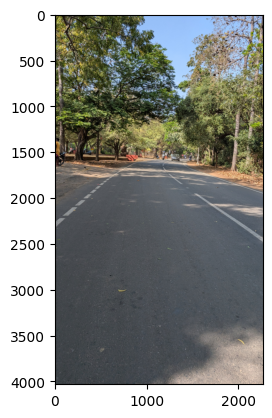

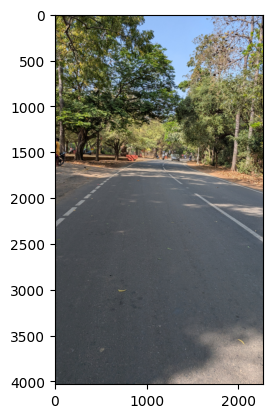

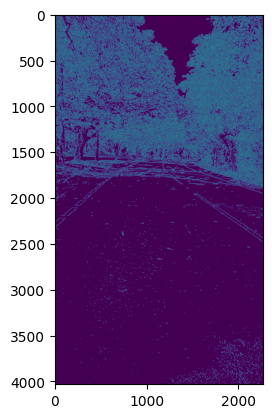

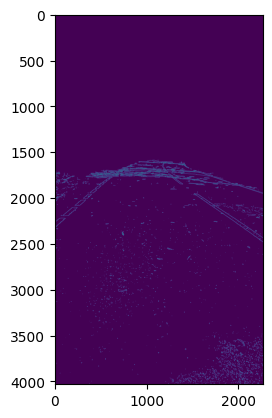

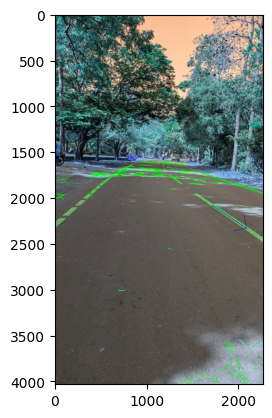

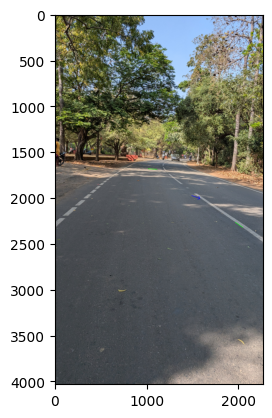

In [6]:
import numpy as np
import cv2
import torch
from PIL import Image
from models import UNET, transform
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load model once
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNET().to(device)
model.load_state_dict(torch.load(r"C:\Users\Mayank\Desktop\Lane_det\segmentation_torch_unet.pth", map_location=device, weights_only=True))
model.eval()

# Function to ensure image is RGB
def ensure_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[2] == 3 else image

# Get segmentation mask from model
def get_segmentation_mask(frame):
    try:
        frame_rgb = ensure_rgb(frame)
        img = Image.fromarray(frame_rgb)
        final_img = transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            mask = model(final_img)
        
        output = (mask > 0.5).squeeze(0).permute(1, 2, 0).cpu().numpy()
        return output
    except Exception as e:
        print(f"Error in segmentation mask: {e}")
        return np.ones((frame.shape[0], frame.shape[1]))

# Adaptive Canny Edge Detection
def adaptive_canny(frame):
# try:
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # print(gray.shape)
    # gray = np.where(gray >= 230, 1, 0)
    # print(gray.shape)
    threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    edges = cv2.Canny(gray, threshold * 0.75, threshold)
    # print(edges.shape)
    # plt.imshow(edges,cmap="gray")
    # plt.show()
    return edges
    # except Exception as e:
    #     print("hi")
    #     print(f"Error in Canny edge detection: {e}")
    #     width,height,_=frame.shape
    #     return np.zeros((width,height))

# Dynamic Hough Line Transform
def detect_hough_lines(edges):
    try:
        minLineLength = 50
        maxLineGap = 20
        return cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=minLineLength, maxLineGap=maxLineGap)
    except Exception as e:
        print(f"Error in Hough Line detection: {e}")
        return None

def split_lines(lines):
    left_lines, right_lines = [], []
    
    if lines is None:  # Handle None or empty input safely
        print("Warning: No lines detected!")
        return left_lines, right_lines

    x_coords = [line[0][0] for line in lines]  # Extract x1 values

    if x_coords is None:  # Ensure x_coords is not empty
        print("Warning: No valid x-coordinates found!")
        return left_lines, right_lines
    
    x_coords.sort()  # Sort in place
    xmid = x_coords[len(x_coords) // 2]  # Find the middle x-value

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 <= xmid:
            left_lines.append(line)
        else:
            right_lines.append(line)

    return left_lines, right_lines


# Fit a single line for each lane

from sklearn.cluster import DBSCAN
import numpy as np

def cluster_lines(lines, eps=0.5, min_samples=1):
    if lines is None or len(lines) == 0:
        print("Warning: No lines found for clustering!")
        return []  # Return an empty list instead of causing an error

    # Extract line features: center point (x, y) and angle
    line_features = np.array([
        [(x1 + x2) / 2, (y1 + y2) / 2, np.arctan2(y2 - y1, x2 - x1)] 
        for [[x1, y1, x2, y2]] in lines
    ])

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(line_features)

    # Group lines by the cluster labels
    clustered_lines = []
    unique_labels = set(labels)
    
    # Ignore the noise points which are labeled as -1 by DBSCAN
    for label in unique_labels:
        if label != -1:  # Skip noise
            cluster_indices = np.where(labels == label)[0]
            cluster_center = np.mean([line_features[i] for i in cluster_indices], axis=0)
            # Compute the mean coordinates of the lines in the cluster
            clustered_lines.append([
                [int(cluster_center[0]), int(cluster_center[1]), 
                 int(cluster_center[0] + 100 * np.cos(cluster_center[2])), 
                 int(cluster_center[1] + 100 * np.sin(cluster_center[2]))]
            ])
    
    return clustered_lines



# Lane detection pipeline
def lane_detection_pipeline(frame):
    try:
        frame_rgb = ensure_rgb(frame)
        blurred_frame = cv2.GaussianBlur(frame_rgb, (5,5), 1)
        mask = get_segmentation_mask(frame)
        edges = adaptive_canny(blurred_frame)
        mask_resized = cv2.resize(mask.astype(np.uint8), (edges.shape[1], edges.shape[0]), interpolation=cv2.INTER_NEAREST)
        inverted_mask = 1 - mask_resized
        edges = edges * inverted_mask
        lines = detect_hough_lines(edges)
        left_lines, right_lines = split_lines(lines, frame.shape[1])
        left_lane = cluster_lines(left_lines)
        right_lane = cluster_lines(right_lines)
        return [left_lane, right_lane]
    except Exception as e:
        print(f"Error in lane detection pipeline: {e}")
        return [None, None]

# Draw lanes
def draw_lanes_and_arrow(frame, lines):
    try:
        if lines is None or len(lines) < 2:
            print("Not enough lines to draw midline arrow!")
            return frame

        # Draw individual lane lines
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Compute midline coordinates
        x_start = (lines[0][0][0] + lines[1][0][0]) // 2  # (x1 of first + x1 of second) / 2
        y_start = (lines[0][0][1] + lines[1][0][1]) // 2  # (y1 of first + y1 of second) / 2
        x_end = (lines[0][0][2] + lines[1][0][2]) // 2  # (x2 of first + x2 of second) / 2
        y_end = (lines[0][0][3] + lines[1][0][3]) // 2  # (y2 of first + y2 of second) / 2

        # Draw the midline arrow
        cv2.arrowedLine(frame,  (x_start, y_start),(x_end, y_end),(0, 0, 255), 3, tipLength=0.3)

        return frame  # Return modified frame

    except Exception as e:
        print(f"Error in drawing lanes: {e}")
        return frame  # Return original frame if error

def process_frame(frame):

    frame_rgb = ensure_rgb(frame)
    plt.imshow(frame_rgb)
    plt.show()
    blurred_frame = cv2.GaussianBlur(frame_rgb,(5,5), 1)
    plt.imshow(blurred_frame)
    plt.show()
    mask = get_segmentation_mask(frame)
    plt.imshow(mask)
    edges = adaptive_canny(blurred_frame)
    plt.imshow(edges)
    plt.show()
    mask_resized = cv2.resize(mask.astype(np.uint8), (edges.shape[1], edges.shape[0]), interpolation=cv2.INTER_NEAREST)

    inverted_mask = 1 - mask_resized
    edges = edges * inverted_mask
    plt.imshow(edges)
    plt.show()
    # plt.imshow(edges,cmap="gray")
    # plt.show()
    lines = detect_hough_lines(edges)
    plt.imshow(draw_lanes_and_arrow(frame, lines))
    plt.show()
    if lines is None or len(lines) == 0:  
        print("No lines detected. Returning unprocessed frame.")
        return frame_rgb  # Return the original frame

    left_lines, right_lines = split_lines(lines)

    # Handle missing lane lines
    if not left_lines and right_lines:
        print("No left lines found. Using right lines for both lanes.")
        left_lines = right_lines
    elif not right_lines and left_lines:
        print("No right lines found. Using left lines for both lanes.")
        right_lines = left_lines
    elif not left_lines and not right_lines:
        print("No lane lines detected. Returning unprocessed frame.")
        return frame_rgb  # Return the original frame if no lanes detected

    left_lane = cluster_lines(left_lines)
    right_lane = cluster_lines(right_lines)

    if not left_lane or not right_lane:  
        print("No lane detected after clustering. Returning unprocessed frame.")
        return frame_rgb  # Return original frame if clustering fails

    clustered_lines = [left_lane[0], right_lane[0]]
    return draw_lanes_and_arrow(frame_rgb, clustered_lines)

def trial(frame):
    plt.imshow(process_frame(frame))
    plt.show()

trial(cv2.imread(r"C:\Users\Mayank\Desktop\Lane_det\test_images\example.jpg"))

# def process_video(input_path, output_path):
#     """Reads a video, processes each frame, and saves the output video in MP4 format."""
    
#     # Open the input video
#     cap = cv2.VideoCapture(input_path)
#     if not cap.isOpened():
#         print("Error: Could not open input video.")
#         return
    
#     # Get video properties
#     frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps = cap.get(cv2.CAP_PROP_FPS)  

#     # Ensure FPS is valid
#     if fps <= 0 or fps is None:
#         fps = 30  # Default to 30 FPS if not detected

#     # Define the codec and create VideoWriter object (H.264 encoding for MP4)
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Try 'mp4v' instead of 'avc1'
#     out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))


#     print(f"Processing video: {input_path}")
#     print(f"Output will be saved as: {output_path} (FPS: {fps}, Resolution: {frame_width}x{frame_height})")

#     frame_count = 0

#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             print(f"Processed {frame_count} frames. End of video reached.")
#             break  # Stop when video ends

#         # 🔹 Try processing the frame
#         try:
#             processed_frame = process_frame(frame)  # Apply processing if possible
#             if processed_frame is None:
#                 print(f"Warning: Processed frame is None at frame {frame_count}. Writing original frame instead.")
#                 processed_frame = frame  # Use the original frame if processing fails

#         except Exception as e:
#             print(f"Error processing frame {frame_count}: {e}. Writing original frame instead.")
#             processed_frame = frame  # Use the original frame if processing crashes

#         out.write(processed_frame)  # Write frame to output
#         frame_count += 1

#     cap.release()
#     out.release()

#     print("Processing complete. Video saved.")

#     # Handle GUI-related OpenCV issues
#     try:
#         cv2.destroyAllWindows()
#     except cv2.error:
#         print("Skipping cv2.destroyAllWindows() due to missing GUI support.")

#     # Process video frame by frame
#     frame_count = 0
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             print("End of video reached or error reading frame.")
#             break

#         processed_frame = process_frame(frame)  # Apply processing
#         out.write(processed_frame)  # Save processed frame
        
#         frame_count += 1
#         if frame_count % 50 == 0:
#             print(f"Processed {frame_count} frames...")

#     # Release resources
#     cap.release()
#     out.release()
#     cv2.destroyAllWindows()
    
#     print("✅ Video processing complete!")

# if __name__ == "__main__":
#     # input_video = r"C:\Users\Mayank\Desktop\Lane_det\input.mp4"  # Update with the correct path
#     # output_video = r"C:\Users\Mayank\Desktop\Lane_det\output.mp4"
#     # process_video(input_video, output_video)

# # import os
# # for path in os.listdir("./test_images"):
# #     Img = cv2.imread(os.path.join("test_images",path))
# #     trial(Img)
